In [5]:
import os
import cv2
import csv
import errno
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [11]:

def compose_images(foreground_path, background_path):
    # Make sure the foreground path is valid and open the image
#     assert os.path.exists(foreground_path), 'image path does not exist: {}'.format(foreground_path)
#     assert os.path.splitext(foreground_path)[1].lower() == '.png', 'foreground must be a .png file'
    foreground = Image.open(foreground_path)
    foreground_alpha = np.array(foreground.getchannel(3))
#     assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)
    
    # Make sure the background path is valid and open the image
#     assert os.path.exists(background_path), 'image path does not exist: {}'.format(background_path)
#     assert os.path.splitext(background_path)[1].lower() in ['.png', '.jpg', 'jpeg'], \
#         'foreground must be a .png or .jpg file: {}'.format(foreground_path)
    background = Image.open(background_path)
    background = background.convert('RGBA')
    
    # Rotate the foreground
#     angle_degrees = random.randint(-8, 8)
#     foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    new_size = (512, 512)
    background = background.resize(new_size, resample=Image.BICUBIC)
    # Scale the foreground
    scale = random.random() * .2 + .23 # Pick something between .5 and 1
    new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
    foreground = foreground.resize(new_size, resample=Image.BICUBIC)

    # Add any other transformations here...
    
    # Choose a random x,y position for the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
        'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    paste_position = (random.randint(0, max_xy_position[0]), random.randint(0, max_xy_position[1]))
    
    # Create a new foreground image as large as the background and paste it on top
    new_foreground = Image.new('RGBA', background.size, color = (0, 0, 0, 0))
    new_foreground.paste(foreground, paste_position)
    
    # Extract the alpha channel from the foreground and paste it into a new image the size of the background
    
    alpha_mask = foreground.getchannel(3)

    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(alpha_mask, paste_position)
    composite = Image.composite(new_foreground, background, new_alpha_mask)
    
    # Grab the alpha pixels above a specified threshold
    alpha_threshold = 200 
    mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
    hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
    
    # Get the smallest & largest non-zero values in each dimension and calculate the bounding box
    nz = np.nonzero(hard_mask)
    bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])] 

    return composite, hard_mask, bbox

In [12]:
dataset_dir = '/home/vlados/Documents/Mask_RCNN'
foregrounds_dir = '/home/vlados/Documents/Mask_RCNN/new_test'
backgrounds_dir = '/media/vlados/FreeSpace/Kaggle/Humpback/background'

foregrounds = os.listdir(foregrounds_dir)
backgrounds = os.listdir(backgrounds_dir)
# Create an output directory
output_dir = os.path.join(dataset_dir, 'generated')
try:
    os.mkdir(output_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Create a list to keep track of images and mask annotations
csv_lines = []

# Generate 5 new images
for i in tqdm(range(2200)):
    foreground_path = os.path.join(foregrounds_dir, random.choice(foregrounds))
    background_path = os.path.join(backgrounds_dir, random.choice(backgrounds))
    
#     print(foreground_path)
#     print(background_path)
    
    composite, mask, bbox = compose_images(foreground_path, background_path)
    
    composite_path = os.path.join(output_dir, 'image_{0:04d}.png'.format(i))
    composite.save(composite_path)
    
    mask_path = os.path.join(output_dir, 'mask_{0:04d}.png'.format(i))
    mask.save(mask_path)
    
    csv_lines.append([composite_path, bbox, mask_path])
    
# Output the annotations csv
annotations_csv_path = os.path.join(output_dir, 'annotations.csv')
with open(annotations_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for csv_line in csv_lines:
        writer.writerow(csv_line)

  2%|▏         | 41/2200 [00:08<07:20,  4.91it/s]/home/vlados/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 2200/2200 [07:50<00:00,  4.93it/s]


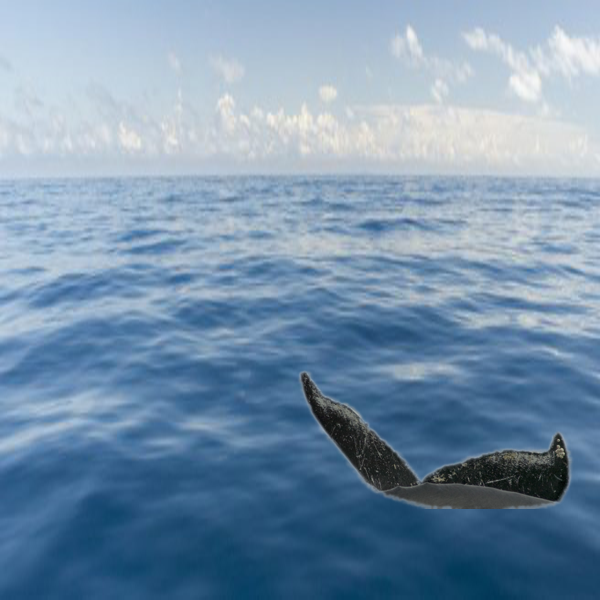

In [27]:
sample_image_path = csv_lines[0][0]
sample_image = Image.open(sample_image_path)
sample_image